# Постановка задачи

Чтобы привлекать больше водителей в период пиковой нагрузки на исторические данных о заказах такси в аэропортах нужно спрогнозировать количество заказов такси на следующий час. Нужно построить модель для такого предсказания.
Значение метрики RMSE на тестовой выборке должно быть не больше 48.

# Шаг 1. Загрузка данных.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

import os
import time
import itertools
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.iolib.table import SimpleTable

from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
path_review = '/datasets/taxi.csv'
my_path = '/Users/Ideapad S145/Desktop/Data_Science/10.Модуль Временные ряды/Практика/taxi.csv'

if os.path.exists(path_review):
    df = pd.read_csv(path_review, sep=',', index_col=[0], parse_dates=[0])
elif os.path.exists(my_path):
    df = pd.read_csv(my_path, sep=',', index_col=[0], parse_dates=[0])
else:
    print("Проверьте правильность пути к датасету")

In [3]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Сделаем ресемплирование по часовому таймфрейму

In [5]:
df_1H = df.resample('1H').sum()
df_1W = df.resample('1W').sum()
df_1D = df.resample('1D').sum()
df_1M = df.resample('1M').sum()

# Шаг 2. Проведем анализ данных.

Посмотрим динамику изменения заказаов по месячно и по дням.

Text(0.5, 1.0, 'Ежемесячная динамика среднего заказов в дневном тайфрейме')

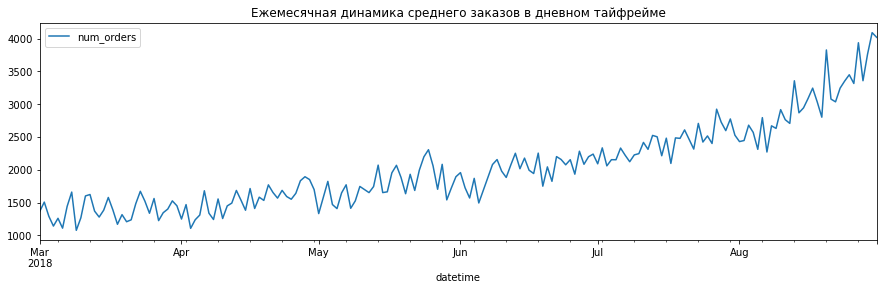

In [6]:
plt.figure(figsize=(15, 4))
df_1D.plot(ax=plt.gca())
plt.title('Ежемесячная динамика среднего заказов в дневном тайфрейме')

Text(0.5, 1.0, 'Ежемесячная динамика среднего заказов в месячном тайфрейме')

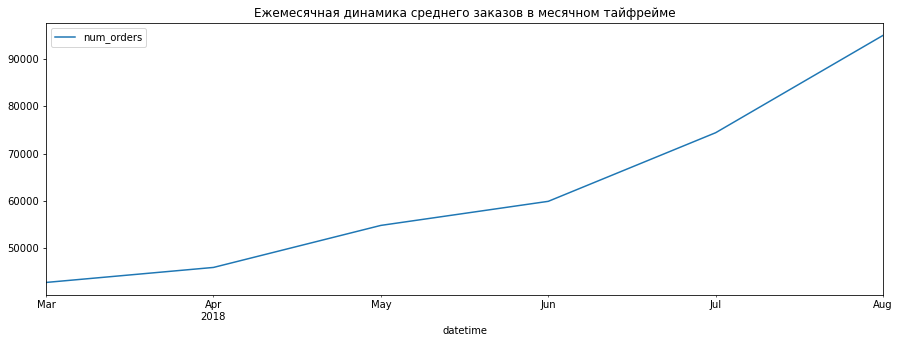

In [7]:
plt.figure(figsize=(15, 5))
df_1M.plot(ax=plt.gca())
plt.title('Ежемесячная динамика среднего заказов в месячном тайфрейме')

Из графиков видно видно наличие устойчивого нелинейного тренда на рост заказов. В дневных и месячных таймфреймах сезонных колебаний не наблюдается.

Посмотрим динамику заказов в часов таймфрейме на полной неделе понедельник-воскресенье

Text(0.5, 1.0, 'Ежемесячная динамика среднего заказов в часовом тайфрейме')

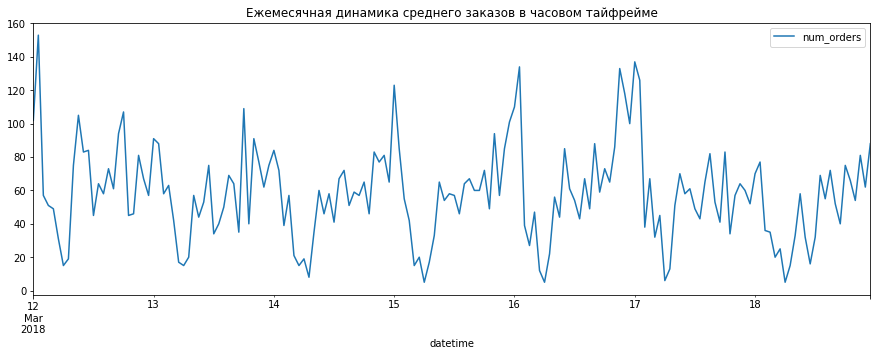

In [8]:
plt.figure(figsize=(15, 5))
df_1H['2018-03-12':'2018-03-18'].plot(ax=plt.gca())
plt.title('Ежемесячная динамика среднего заказов в часовом тайфрейме')

В динамике за неделю в часом таймфрейме мы наблюдаем ярковыраженную картину сезонных внутри дневных колебаний. Посмотрим динамику изменения заказов внутри дня.

Text(0.5, 1.0, 'Ежемесячная динамика среднего заказов в часовом тайфрейме')

<Figure size 1080x360 with 0 Axes>

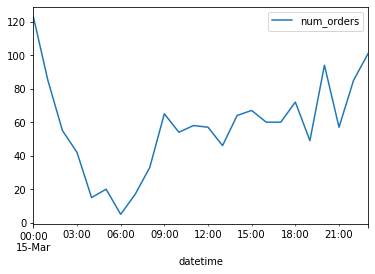

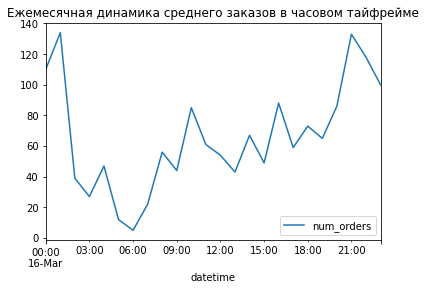

In [9]:
plt.figure(figsize=(15, 5))
df_1H['2018-03-15'].plot()
df_1H['2018-03-16'].plot()
plt.title('Ежемесячная динамика среднего заказов в часовом тайфрейме')

Мы наблюдаем большой пик заказов в районе 24:00 часов и минимум в районе 06:00 часов

Построим графики автокорреляции

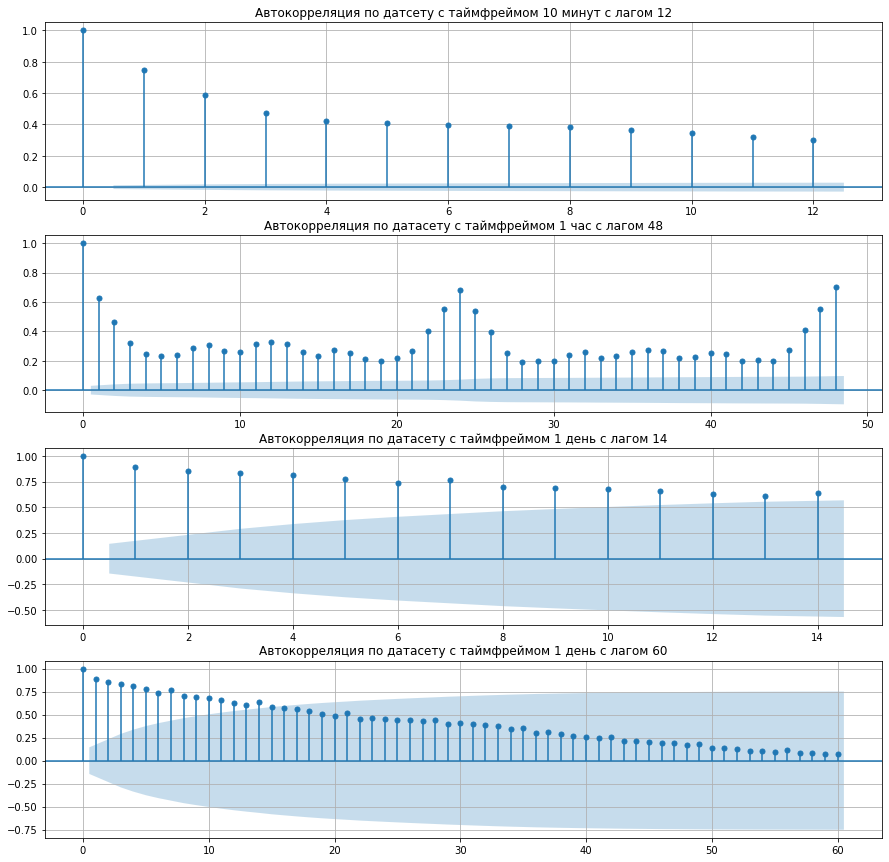

In [10]:
list_data = [df, df_1H, df_1D, df_1D]
list_subplot = [411, 412, 413, 414]
lags = [12, 48, 14, 60]
title = ['Автокорреляция по датсету с таймфреймом 10 минут', 
         'Автокорреляция по датасету с таймфреймом 1 час',
         'Автокорреляция по датасету с таймфреймом 1 день',
         'Автокорреляция по датасету с таймфреймом 1 день']
plt.figure(figsize=(15, 15))
for data, sub, tit, lag in zip(list_data, list_subplot, title, lags):
    plt.subplot(sub)
    plot_acf(data, alpha = 0.05, ax=plt.gca(), lags=lag, title=tit + ' с лагом ' + str(lag))
    plt.grid(True)
plt.show()

В часовом таймфрейме видно всплески значений автокорреляции точках 8, 13, 18 и 24, что говорит о наличии сезонности в соответствующих лагах.
На остальных графиках автокорреляции не наблюдается.

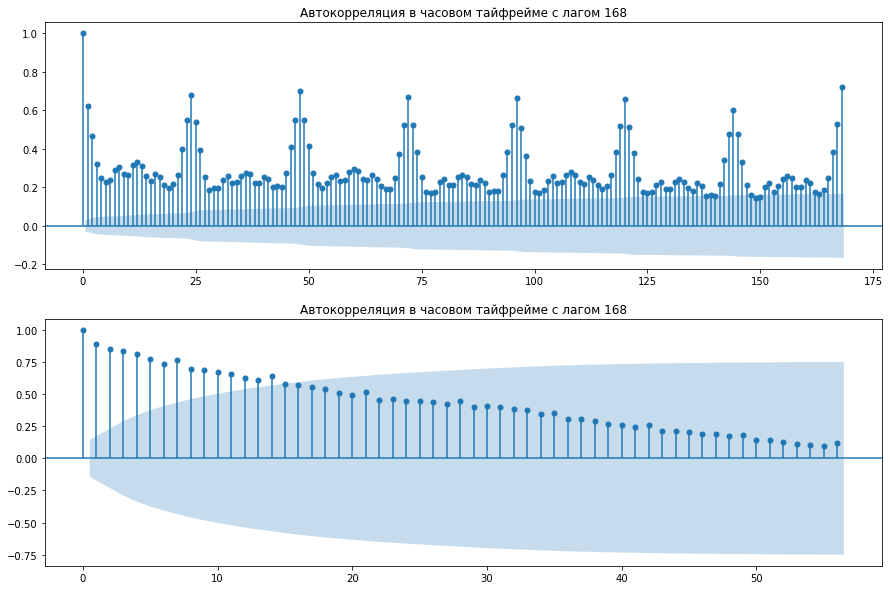

In [11]:
plt.figure(figsize=(15, 10))
plt.subplot(211)
plot_acf(df_1H, alpha = 0.05, ax=plt.gca(), lags=168, title='Автокорреляция в часовом тайфрейме с лагом 168')

plt.subplot(212)
plot_acf(df_1D, alpha = 0.05, ax=plt.gca(), lags=56, title='Автокорреляция в часовом тайфрейме с лагом 168')
plt.show()

Построим графики частично автокорреляции

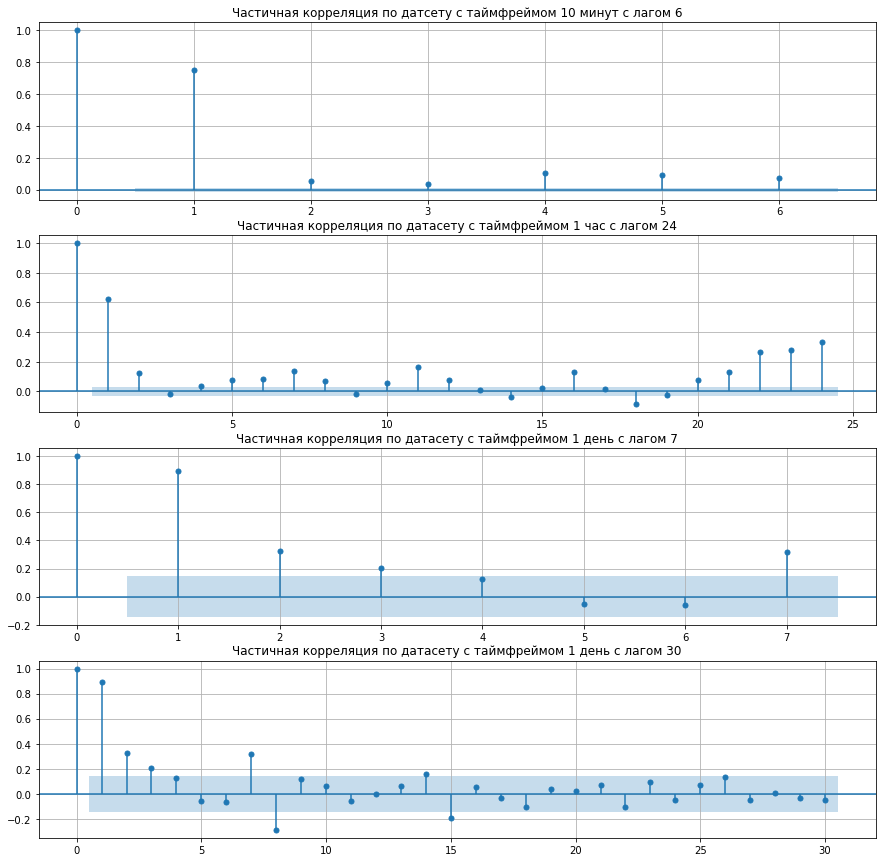

In [12]:
list_data = [df, df_1H, df_1D, df_1D]
list_subplot = [411, 412, 413, 414]
lags = [6, 24, 7, 30]
title = ['Частичная корреляция по датсету с таймфреймом 10 минут', 
         'Частичная корреляция по датасету с таймфреймом 1 час',
         'Частичная корреляция по датасету с таймфреймом 1 день',
         'Частичная корреляция по датасету с таймфреймом 1 день']
plt.figure(figsize=(15, 15))
for data, sub, tit, lag in zip(list_data, list_subplot, title, lags):
    plt.subplot(sub)
    plot_pacf(data, alpha = 0.05, ax=plt.gca(), lags=lag, title=tit + ' с лагом ' + str(lag))
    plt.grid(True)
plt.show()

**Резюме.**<br>
У нас есть исходный временной ряд заказов такси в аэропортй в 1-минутном таймфрейме. Было сделано ресемплирование по часовым, дневным, недельным и месячным таймфреймам. На основании проведенного анализа выявлено наличие устойчивого нелинейного растущего тренда и наличие сезонности в часовых таймфреймах внутри дня. Картинка сезонности подтвердилась на графике автокорреляции.<br>
Таким образом, у нас нестационарный временянной ряд с сезонным колебаниям внутри дня.

# Шаг 3. Обучение нескольких моделей с различными гиперпараметрами. Создание тестовой выборки размером 10% от исходных данных.

Сдеаем три модели прогнозирования - случайный лес, градиентный бустинг и SARIMA.<br>
Для моделей случайного леса и градиентного бустинг дополним наш временной ряд новыми признаками - месяц, день, час, а также несколько сдвигов. Посмотрим коррелляцию признаков и удалим сильно коррелирующие.

In [13]:
df_1H['month'] = df_1H.index.month
df_1H['dayofweek'] = df_1H.index.dayofweek
df_1H['hour'] = df_1H.index.hour

Сделаем 23 лага для каждого часа в сутках

In [14]:
for lag in range(1, 4):
    df_1H['lag_{}'.format(lag)] = df_1H.num_orders.shift(lag)

In [15]:
df_1H['rolling_24'] = df_1H.num_orders.rolling(24).mean()

Удалим объекты с NaN

In [16]:
df_1H = df_1H.dropna()

Выделим тестовую выборку в размере 10% исходной выборки.

In [17]:
train, test = train_test_split(df_1H, shuffle=False, test_size=0.1)
train, valid = train_test_split(train, shuffle=False, test_size=0.1)

In [18]:
X_train = train.drop('num_orders', axis=1)
y_train = train.num_orders

X_valid = valid.drop('num_orders', axis=1)
y_valid = valid.num_orders

X_test = test.drop('num_orders', axis=1)
y_test = test.num_orders

Отмасштабируем данные. 

In [19]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

**Модель случайный лес**

In [20]:
models = []
for est in [100, 200]:
    for depth in [8]:
        model_rfr = RandomForestRegressor(n_estimators=est, max_depth=depth, random_state=123)
        model_rfr.fit(X_train, y_train)
        rmse = mean_squared_error(y_valid, model_rfr.predict(X_valid))**0.5
        models.append(['Случайный лес', model_rfr, rmse])

**Модель lgb**

In [21]:
for est in [1000,10000]:
    for depth in [1]:
        for l_rate in [0.1, 0.5, 0.9]:
            model_lgb = lgb.LGBMRegressor(objective='regression', 
                                          n_estimators=est, 
                                          learning_rate=l_rate, 
                                          max_depth=depth, 
                                          random_state=123)
            model_lgb.fit(X_train, y_train)
            rmse = mean_squared_error(y_valid, model_lgb.predict(X_valid))**0.5
            models.append(['LGBMRegressor', model_lgb, rmse])

In [22]:
sorted(models, key=lambda x: x[2], reverse=True)[0]

['LGBMRegressor',
 LGBMRegressor(learning_rate=0.9, max_depth=1, n_estimators=10000,
               objective='regression', random_state=123),
 34.07781160401678]

Лучшей моделью на подборе оказалась LGBMRegressor(learning_rate=0.9, max_depth=1, n_estimators=10000, objective='regression', random_state=123) с метрикой RMSE на валидационной выборке равной 36,5983.

In [23]:
best_model = sorted(models, key=lambda x: x[2], reverse=True)[0][1]
rmse_test = mean_squared_error(y_test, best_model.predict(X_test))**0.5
print('Значение метрики RMSE на тестовой выборке =', rmse_test)

Значение метрики RMSE на тестовой выборке = 47.89960559044994


Результат неплохой.

**Модель SARIMAX**

In [24]:
sarimax_train = pd.concat([y_train, y_valid])

In [25]:
model=sm.tsa.statespace.SARIMAX(sarimax_train, 
                                order=(1, 1, 2), 
                                seasonal_order=(1, 1, 1, 24)).fit(disp=-1)

In [26]:
sarima_pred = model.predict(start = len(sarimax_train), end = len(sarimax_train) + len(y_test) - 1)
rmse_test = mean_squared_error(y_test, sarima_pred)**0.5
print('Значение метрики RMSE на тестовой выборке =', round(rmse_test, 4))

Значение метрики RMSE на тестовой выборке = 41.4998


Результат удовлетворяет требованиям Заказчика - RMSE менее 48

Посмотрим результат работы модели SARIMAX на графике c 2018-08-10 по 2018-08-31

Text(0.5, 1.0, 'Динамика значений заказов на тестовой выборке в часовых таймфреймах и предсказание модели SARIMAX')

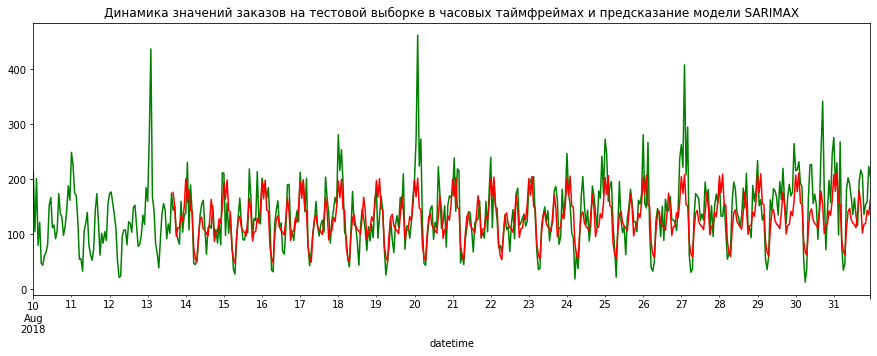

In [27]:
plt.figure(figsize=(15, 5))
df_1H.num_orders['2018-08-10':'2018-08-31'].plot(ax=plt.gca(), color='green')
sarima_pred.plot(ax=plt.gca(), color='red')
plt.title('Динамика значений заказов на тестовой выборке в часовых таймфреймах и предсказание модели SARIMAX')

# Резюме.

**В результате подбора лучшей моделью предсказания вызовов такси оказалась модель SARIMAX(1, 1, 2, 1, 1, 1), которая показала значение метрики RMSE на тестовой выборке равной 41,4998, что меньше минимально допустимого значения 48.<br>
График предсказаных значений моделью довольно точно описывает динамику изменения заказов тестовой выборки с учетом внутридневной сезонности в часовых таймофреймах.**